In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import all the Libraries

In [ ]:
import cv2
import numpy as np
import skimage.morphology
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import math
from google.colab.patches import cv2_imshow

Load the Dataset


##Extract Features

In [ ]:
class MinutiaeFeature(object):
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX
        self.locY = locY
        self.Orientation = Orientation
        self.Type = Type

class FingerprintFeatureExtractor(object):
    def __init__(self):
        self._mask = []
        self._skel = []
        self.minutiaeTerm = []
        self.minutiaeBif = []
        self._spuriousMinutiaeThresh = 10

    def setSpuriousMinutiaeThresh(self, spuriousMinutiaeThresh):
        self._spuriousMinutiaeThresh = spuriousMinutiaeThresh

    def __skeletonize(self, img):
        img = np.uint8(img > 128)
        self._skel = skimage.morphology.skeletonize(img)
        self._skel = np.uint8(self._skel) * 255
        self._mask = img * 255

    def __computeAngle(self, block, minutiaeType):
        angle = []
        (blkRows, blkCols) = np.shape(block)
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        if (minutiaeType.lower() == 'termination'):
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
                        if (sumVal > 1):
                            angle.append(float('nan'))
            return (angle)

        elif (minutiaeType.lower() == 'bifurcation'):
            (blkRows, blkCols) = np.shape(block)
            CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
            angle = []
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
            if (sumVal != 3):
                angle.append(float('nan'))
            return (angle)

    def __getTerminationBifurcation(self):
        self._skel = self._skel == 255
        (rows, cols) = self._skel.shape
        self.minutiaeTerm = np.zeros(self._skel.shape)
        self.minutiaeBif = np.zeros(self._skel.shape)

        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                if (self._skel[i][j] == 1):
                    block = self._skel[i - 1:i + 2, j - 1:j + 2]
                    block_val = np.sum(block)
                    if (block_val == 2):
                        self.minutiaeTerm[i, j] = 1
                    elif (block_val == 4):
                        self.minutiaeBif[i, j] = 1

        self._mask = convex_hull_image(self._mask > 0)
        self._mask = erosion(self._mask, square(5))  # Structuing element for mask erosion = square(5)
        self.minutiaeTerm = np.uint8(self._mask) * self.minutiaeTerm

    def __removeSpuriousMinutiae(self, minutiaeList, img):
        img = img * 0
        SpuriousMin = []
        numPoints = len(minutiaeList)
        D = np.zeros((numPoints, numPoints))
        for i in range(1,numPoints):
            for j in range(0, i):
                (X1,Y1) = minutiaeList[i]['centroid']
                (X2,Y2) = minutiaeList[j]['centroid']

                dist = np.sqrt((X2-X1)**2 + (Y2-Y1)**2)
                D[i][j] = dist
                if(dist < self._spuriousMinutiaeThresh):
                    SpuriousMin.append(i)
                    SpuriousMin.append(j)

        SpuriousMin = np.unique(SpuriousMin)
        for i in range(0,numPoints):
            if(not i in SpuriousMin):
                (X,Y) = np.int16(minutiaeList[i]['centroid'])
                img[X,Y] = 1

        img = np.uint8(img)
        return(img)

    def __cleanMinutiae(self, img):
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2)
        RP = skimage.measure.regionprops(self.minutiaeTerm)
        self.minutiaeTerm = self.__removeSpuriousMinutiae(RP, np.uint8(img))

    def __performFeatureExtraction(self):
        FeaturesTerm = []
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2)
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeTerm))

        WindowSize = 2  # --> For Termination, the block size must can be 3x3, or 5x5. Hence the window selected is 1 or 2
        FeaturesTerm = []
        for num, i in enumerate(RP):
            (row, col) = np.int16(np.round(i['Centroid']))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Termination')
            if(len(angle) == 1):
                FeaturesTerm.append(MinutiaeFeature(row, col, angle, 'Termination'))

        FeaturesBif = []
        self.minutiaeBif = skimage.measure.label(self.minutiaeBif, connectivity=2)
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeBif))
        WindowSize = 1  # --> For Bifurcation, the block size must be 3x3. Hence the window selected is 1
        for i in RP:
            (row, col) = np.int16(np.round(i['Centroid']))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Bifurcation')
            if(len(angle) == 3):
                FeaturesBif.append(MinutiaeFeature(row, col, angle, 'Bifurcation'))
        return (FeaturesTerm, FeaturesBif)

    def extractMinutiaeFeatures(self, img):
        self.__skeletonize(img)

        self.__getTerminationBifurcation()

        self.__cleanMinutiae(img)

        FeaturesTerm, FeaturesBif = self.__performFeatureExtraction()
        return(FeaturesTerm, FeaturesBif)

    def showResults(self, FeaturesTerm, FeaturesBif):

        (rows, cols) = self._skel.shape
        DispImg = np.zeros((rows, cols, 3), np.uint8)
        DispImg[:, :, 0] = 255*self._skel
        DispImg[:, :, 1] = 255*self._skel
        DispImg[:, :, 2] = 255*self._skel

        for idx, curr_minutiae in enumerate(FeaturesTerm):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255))

        for idx, curr_minutiae in enumerate(FeaturesBif):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))

        cv2_imshow(DispImg)
        cv2.waitKey(0)

        return DispImg

    def saveResult(self, FeaturesTerm, FeaturesBif):
        (rows, cols) = self._skel.shape
        DispImg = np.zeros((rows, cols, 3), np.uint8)
        DispImg[:, :, 0] = 255 * self._skel
        DispImg[:, :, 1] = 255 * self._skel
        DispImg[:, :, 2] = 255 * self._skel

        for idx, curr_minutiae in enumerate(FeaturesTerm):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255))

        for idx, curr_minutiae in enumerate(FeaturesBif):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))
        cv2.imwrite('result.png', DispImg)

def extract_minutiae_features(img, spuriousMinutiaeThresh=10, invertImage=False, showResult=False, saveResult=False):
    feature_extractor = FingerprintFeatureExtractor()
    feature_extractor.setSpuriousMinutiaeThresh(spuriousMinutiaeThresh)
    if (invertImage):
        img = 255 - img;

    FeaturesTerm, FeaturesBif = feature_extractor.extractMinutiaeFeatures(img)

    if (saveResult):
        feature_extractor.saveResult(FeaturesTerm, FeaturesBif)

    if(showResult):
        DispImg=feature_extractor.showResults(FeaturesTerm, FeaturesBif)

    return(DispImg,FeaturesTerm, FeaturesBif)

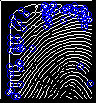

In [ ]:
# img = cv2.imread('/content/drive/MyDrive/Biometrics/Real/172__M_Left_index_finger.BMP', 0)				# read the input image --> You can enhance the fingerprint image using the "fingerprint_enhancer" library
# orgimg,FeaturesTerminations, FeaturesBifurcations = extract_minutiae_features(img, spuriousMinutiaeThresh=10, invertImage = False, showResult=True, saveResult = True)
# img.shape
# database_features = FeaturesTerminations + FeaturesBifurcations  # Database features


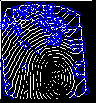

In [ ]:
# img = cv2.imread('/content/drive/MyDrive/Biometrics/Altered/171__M_Left_index_finger_Zcut.BMP', 0)				# read the input image --> You can enhance the fingerprint image using the "fingerprint_enhancer" library
# alteredimg, FeaturesTerminations, FeaturesBifurcations = extract_minutiae_features(img, spuriousMinutiaeThresh=10, invertImage = False, showResult=True, saveResult = True)
# img.shape
# test_features = FeaturesTerminations + FeaturesBifurcations  # Test features


In [ ]:
# original_image = orgimg.astype(np.uint8)
# altered_image = alteredimg.astype(np.uint8)

##Metrics

In [ ]:
# Define the method for template matching
method = cv2.TM_CCOEFF

# Perform template matching
try:
    result = cv2.matchTemplate(altered_image, original_image, method)
    _, max_val, _, max_loc = cv2.minMaxLoc(result)
    print("Matching result:", max_val)
    print("Location of best match (top-left corner):", max_loc)

    # Get the dimensions of the template image
    h, w = original_image.shape[:2]

    # Draw a rectangle around the matched region
    matched_image = altered_image.copy()
    cv2.rectangle(matched_image, max_loc, (max_loc[0] + w, max_loc[1] + h), (0, 255, 0), 2)

    # Display the image with the matched region highlighted
    cv2.imshow('Matched Image', matched_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
except cv2.error as e:
    print("OpenCV Error:", e)


Matching result: 32812856.0


In [ ]:
# import cv2

# # Extract keypoints and descriptors for the test image
# sift = cv2.SIFT_create()
# kp_test, des_test = sift.detectAndCompute(altered_image, None)

# # Loop through each database image and find the best match using feature matching
# best_match_index = -1
# best_match_distance = float('inf')
# # for i, database_image in enumerate(database_images):
# kp_db, des_db = sift.detectAndCompute(original_image, None)
# bf = cv2.BFMatcher()
# matches = bf.knnMatch(des_test, des_db, k=2)
# good_matches = []
# for m, n in matches:
#     if m.distance < 0.75 * n.distance:
#         good_matches.append([m])
# if len(good_matches) < best_match_distance:
#    best_match_distance = len(good_matches)
#   #  best_match_index =

# best_match_distance

0